In [56]:
#Load the necesssary libraries
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,accuracy_score,f1_score,confusion_matrix,matthews_corrcoef
from sklearn.metrics import precision_score, recall_score
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
import seaborn as sns
%matplotlib inline

#### We will start the process by loading the cleaned datasets of Arabica and Robusta.

In [2]:
#Load the datasets
df_arabica=pd.read_csv('arabica_data_cleaned.csv',index_col=[0])
df_robusta=pd.read_csv('robusta_data_cleaned.csv',index_col=[0])

In [3]:
#Let us explore the top 5 rows of arabica dataset
df_arabica.head()

,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
3,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
4,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,oromia,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
5,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [4]:
#Let us explore the top 5 rows of robusta dataset
df_robusta.head()

,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
1,Robusta,ankole coffee producers coop,Uganda,kyangundu cooperative society,NaN,ankole coffee producers,0,ankole coffee producers coop,1488,sheema south western,...,Green,2,"June 26th, 2015",Uganda Coffee Development Authority,e36d0270932c3b657e96b7b0278dfd85dc0fe743,03077a1c6bac60e6f514691634a7f6eb5c85aae8,m,1488.0,1488.0,1488.0
2,Robusta,nishant gurjer,India,sethuraman estate kaapi royale,25,sethuraman estate,14/1148/2017/21,kaapi royale,3170,chikmagalur karnataka indua,...,NaN,2,"October 31st, 2018",Specialty Coffee Association,ff7c18ad303d4b603ac3f8cff7e611ffc735e720,352d0cf7f3e9be14dad7df644ad65efc27605ae2,m,3170.0,3170.0,3170.0
3,Robusta,andrew hetzel,India,sethuraman estate,NaN,NaN,0000,sethuraman estate,1000m,chikmagalur,...,Green,0,"April 29th, 2016",Specialty Coffee Association,ff7c18ad303d4b603ac3f8cff7e611ffc735e720,352d0cf7f3e9be14dad7df644ad65efc27605ae2,m,1000.0,1000.0,1000.0
4,Robusta,ugacof,Uganda,ugacof project area,NaN,ugacof,0,ugacof ltd,1212,central,...,Green,7,"July 14th, 2015",Uganda Coffee Development Authority,e36d0270932c3b657e96b7b0278dfd85dc0fe743,03077a1c6bac60e6f514691634a7f6eb5c85aae8,m,1212.0,1212.0,1212.0
5,Robusta,katuka development trust ltd,Uganda,katikamu capca farmers association,NaN,katuka development trust,0,katuka development trust ltd,1200-1300,luwero central region,...,Green,3,"June 26th, 2015",Uganda Coffee Development Authority,e36d0270932c3b657e96b7b0278dfd85dc0fe743,03077a1c6bac60e6f514691634a7f6eb5c85aae8,m,1200.0,1300.0,1250.0


#### Let us combine both the datasets for understanding Robusta and Arabica datasets and perform EDA. For that we need to change the columns of Robusta dataset to match with Arabica.

In [5]:
#change the column names
df_robusta.columns=list(df_arabica.columns)

In [6]:
#combine the two data sets into one
df=pd.concat([df_arabica,df_robusta])

In [7]:
print('Arabica Dataset size:'+str(df_arabica.shape))
print('Robusta Dataset size:'+str(df_robusta.shape))
print('Combined Dataset size:'+str(df.shape))

Arabica Dataset size:(1311, 43)
Robusta Dataset size:(28, 43)
Combined Dataset size:(1339, 43)


Text(0, 0.5, 'Frequency')

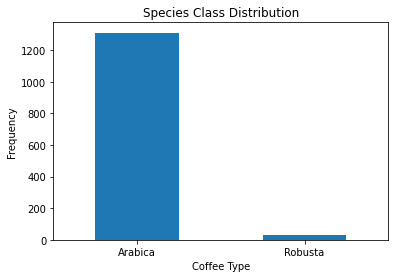

In [8]:
#plot the distributions of arabica and robusta coffees
count_classes = pd.value_counts(df['Species'])

count_classes.plot(kind = 'bar', rot=0)

plt.title("Species Class Distribution")


plt.xlabel("Coffee Type")

plt.ylabel("Frequency")

#### We can see that we are dealing with a highly imbalanced dataset. We may need to apply some over sampling techniques before building a classification model.

Text(0, 0.5, 'Country Of Origin')

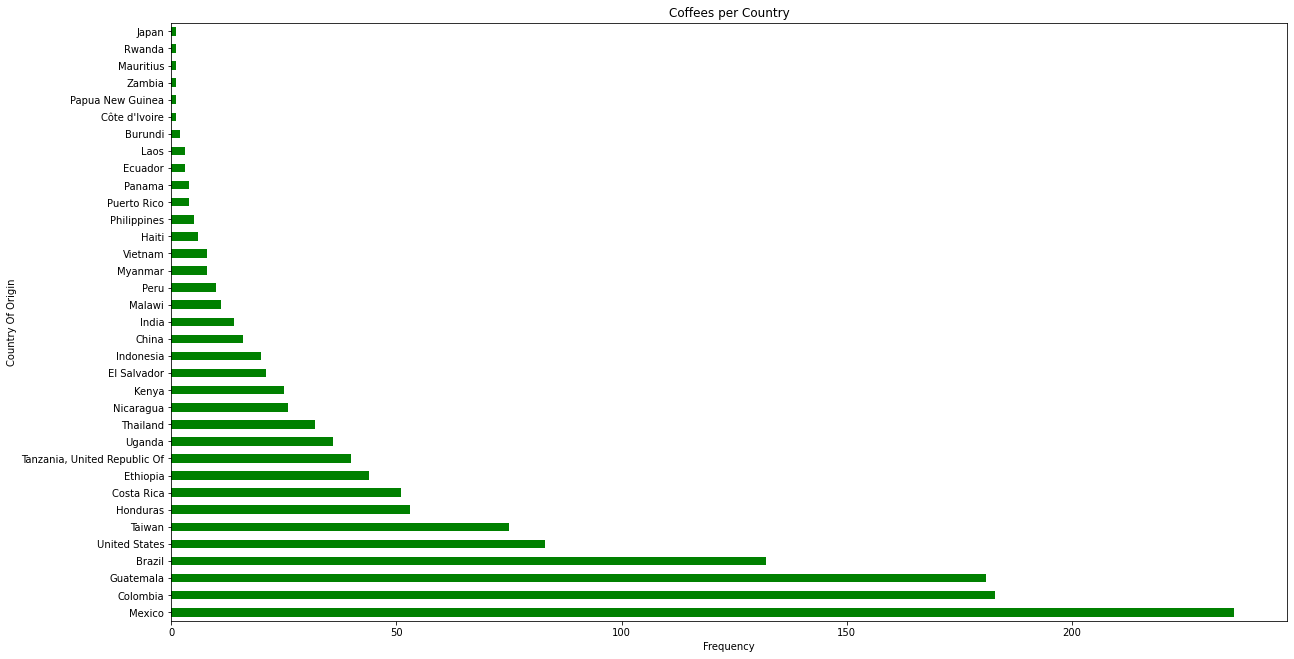

In [9]:
#change the country name of Coted?Ivoire to Côte d'Ivoire
df['Country.of.Origin'] = df['Country.of.Origin'].replace('Cote d?Ivoire',"Côte d'Ivoire")
df['Country.of.Origin'] = df['Country.of.Origin'].replace('United States (Hawaii)','United States')
df['Country.of.Origin'] = df['Country.of.Origin'].replace('United States (Puerto Rico)','Puerto Rico')
#plot the countries of origin
plt.rcParams["figure.figsize"] = (20,11)
df['Country.of.Origin'].value_counts().plot(kind='barh',color='green')
plt.title('Coffees per Country')

plt.xlabel("Frequency")

plt.ylabel("Country Of Origin")

#### From the graph, we can say that over 50 percent of datatset consists of coffee from Mexico,Columbia,Guatemala and Brazil.

#### We will try to visualise country of origins and their total average cupping scores in our dataset.

In [10]:
#Find the average of all total cup points grouping by country name
score_df=df.groupby('Country.of.Origin')['Total.Cup.Points'].mean().reset_index(name='Total_Avg_Points')

#function to convert to alpah2 country codes and continents
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_continent)


#The below code is to get the countries alpha2 code and continent code from the score_df country of origin and append codes
Codes_list=[]
Country_list=[]
Conti_list=[]
for i in score_df['Country.of.Origin']:
    Codes_list.append(get_continent(i))
    Country_list.append(get_continent(i)[0])
    Conti_list.append(get_continent(i)[1])
score_df['codes']=Codes_list
score_df['Country']=Country_list
score_df['Continent']=Conti_list


#function to get longitude and latitude data from country name
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="get_country")
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

#The below code is to get the coordinates for the countries based on the alpha2 code 
Geolocations=[]
for i in score_df['Country']:
    Geolocations.append(geolocate(i))
    
#add the coordinates column to the score_df dataframe
score_df['Geolocate']=Geolocations

#Let's see the final score dataframe after all these operations
score_df

,Country.of.Origin,Total_Avg_Points,codes,Country,Continent,Geolocate
0,Brazil,82.405909,"(BR, SA)",BR,SA,"(-10.3333333, -53.2)"
1,Burundi,81.830000,"(BI, AF)",BI,AF,"(50.6402809, 4.6667145)"
2,China,82.927500,"(CN, AS)",CN,AS,"(35.000074, 104.999927)"
3,Colombia,83.106557,"(CO, SA)",CO,SA,"(2.8894434, -73.783892)"
4,Costa Rica,82.789020,"(CR, NA)",CR,NA,"(45.22086405, 10.037037979628856)"
5,Côte d'Ivoire,79.330000,"(CI, AF)",CI,AF,"(7.9897371, -5.5679458)"
6,Ecuador,80.220000,"(EC, SA)",EC,SA,"(-1.3397668, -79.3666965)"
7,El Salvador,83.052857,"(SV, NA)",SV,NA,"(13.8000382, -88.9140683)"
8,Ethiopia,85.484091,"(ET, AF)",ET,AF,NaN
9,Guatemala,81.846575,"(GT, NA)",GT,NA,"(32.3293809, -83.1137366)"


In [11]:
#There are 3 missing values. Let us manually get the cordinates for the missing countries
#9.1450° N, 40.4897° E  #ET
#20.5937° N, 78.9629° E  #IN
#19.8563° N, 102.4955° E #LA Source:google

#replacing null values with tuples is not easy, so a small workaround to do that 
filler=[1,2,3]
score_df.loc[score_df.Geolocate.isnull(), 'Geolocate'] = filler

m = score_df['Geolocate'].eq(1)
score_df['Geolocate'] = score_df.loc[~m, 'Geolocate'].reindex(m.index, fill_value=(9.1450,40.4897)) #ET

m = score_df['Geolocate'].eq(2)
score_df['Geolocate'] = score_df.loc[~m, 'Geolocate'].reindex(m.index, fill_value=(20.5937,78.9629)) #IN

m = score_df['Geolocate'].eq(3)
score_df['Geolocate'] = score_df.loc[~m, 'Geolocate'].reindex(m.index, fill_value=(19.8563,102.4955)) #LA

#split the Geolocate columns to Latitude and Longitude
score_df[['Latitude', 'Longitude']] = pd.DataFrame(score_df['Geolocate'].tolist(), index=score_df.index)


In [12]:
# Create a world map to show total cupper points for all countries in the dataset

#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(score_df)):
        lat = score_df.iloc[i]['Latitude']
        long = score_df.iloc[i]['Longitude']
        radius=5
        popup_text = """Country : {}<br>
                    Total Avg Points : {}<br>"""
        popup_text = popup_text.format(score_df.iloc[i]['Country.of.Origin'],
                                   round(score_df.iloc[i]['Total_Avg_Points'],2)
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

#### Here is the world map, you can explore this by zooming in and clicking on the blue coloured circle to get the country name and the total average points.

Text(0.5, 0, 'Average Total Cupping Score')

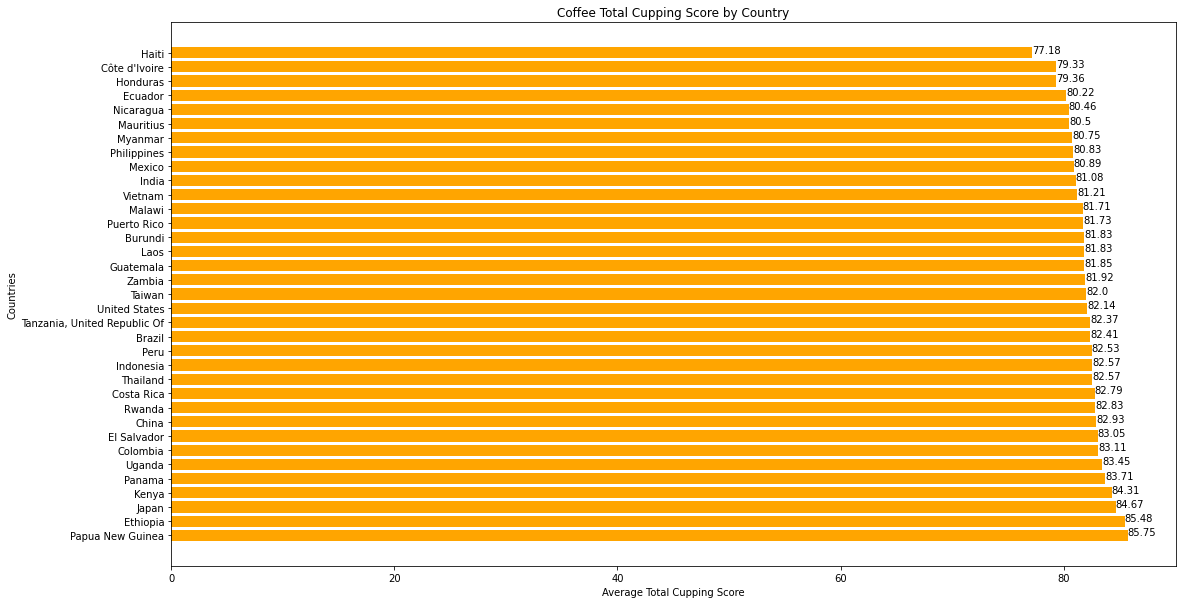

In [13]:
plt.figure(figsize=(18,10))
df_score_desc= score_df.sort_values('Total_Avg_Points',ascending=False)

for index, value in enumerate(df_score_desc['Total_Avg_Points']):
    plt.text(value, index,
             str(round(value,2)))
plt.barh(df_score_desc['Country.of.Origin'],df_score_desc['Total_Avg_Points'],color='orange',)
plt.title('Coffee Total Cupping Score by Country')
plt.ylabel("Countries")
plt.xlabel("Average Total Cupping Score")

#### We can observe from above bar chart that Papua New Guinea has the highest average total cup score followed by Ethiopia and Japan where as Haiti is at the least 

<AxesSubplot:>

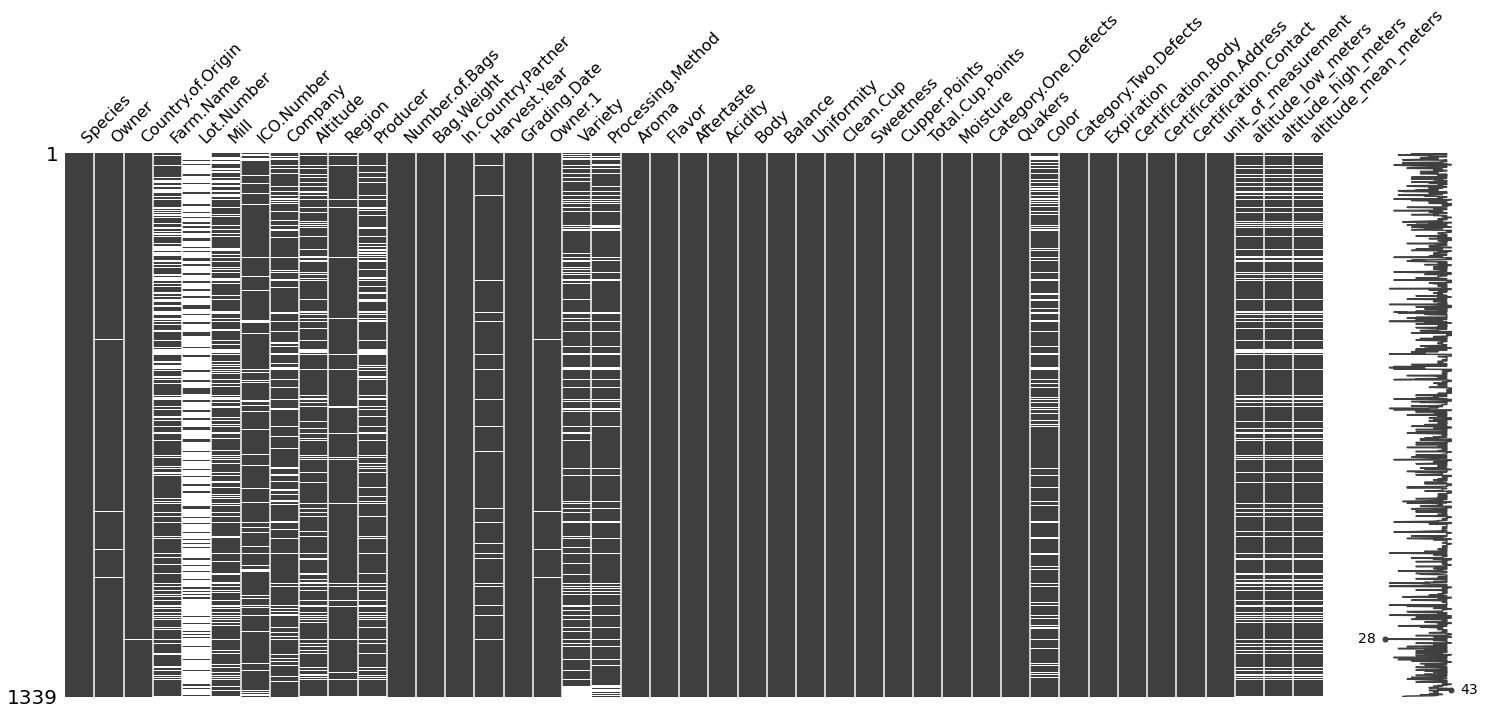

In [14]:
#visualise the missing values
msno.matrix(df)

#### We can observe that the columns like Lot number,Farm Name,altitude_low_meters,altitude_high_meters, altitude_mean_meters,etc have many missing values and we have to remove them. There are some obvious columns like Certification Body, Certification Address,Certification Contact which anyway has to be removed as they contain unidentified text.
#### We shall remove the ICO.Number,Altitude,Region,In Country Partner,Harvest Year,Grading Date from our dataset as it can lead to curse of dimensionality when there are more features and more focus for our problem is on building a good classification model.

#### According to the problem setting and also  [jldbc](https://github.com/jldbc/coffee-quality-database)  I feel 
Aroma
Flavor
Aftertaste
Acidity
Body
Balance
Uniformity
Cup Cleanliness
Sweetness
Moisture
Defects
#### are the important features for the classification model. I also prefer to try with two or more other categorical columns and see if it is making any difference with the correlation matrix. As Marcio likes Brazilian coffee and that too from a place called "Fazenda Kaquend" ,let us keep the Country.of.Origin and Farm.Name columns to see if it has any significance in the model.

#### The altitude_low_meters,  altitude_high_meters and  altitude_mean_meters are having missing values which are missing 

#### completely at random(MCAR). There is no particular way to impute them. So the safest option is removing them to not affect our model.

In [15]:
#Let's clean the dataframe by removing columns as discussed above
df.drop(['Lot.Number','Expiration','Certification.Body','altitude_high_meters',
         'ICO.Number','Altitude','In.Country.Partner','altitude_low_meters','unit_of_measurement',
         'Harvest.Year','Grading.Date','Mill','Number.of.Bags','Bag.Weight','Processing.Method',
         'Color','Certification.Address','Certification.Contact','altitude_mean_meters'
        ],axis=1,inplace=True)

In [16]:
#check owner and owner.1 columns to remove duplicates
print(df['Owner'].value_counts())
print('----------------------------------------------------')
print(df['Owner.1'].value_counts())

juan luis alvarado romero                 155
racafe & cia s.c.a                         60
exportadora de cafe condor s.a             54
kona pacific farmers cooperative           52
ipanema coffees                            50
                                         ... 
tutunze kahawa ltd                          1
almacafe                                    1
maria amalia guadalupe toriello elorza      1
mario jose fernandez                        1
irene alves santos                          1
Name: Owner, Length: 315, dtype: int64
----------------------------------------------------
Juan Luis Alvarado Romero           155
Racafe & Cia S.C.A                   60
Exportadora de Cafe Condor S.A       54
Kona Pacific Farmers Cooperative     52
Ipanema Coffees                      50
                                   ... 
MYRNA ROXANA GALVEZ GONZALEZ          1
CECA,S.A.                             1
Hugo Valdivia                         1
FERNANDO MENDOZA APARICIO             1
An

In [17]:
#remove Owner.1 column as its same as Owner
df.drop(['Owner.1'],axis=1,inplace=True)

In [18]:
#Check the missing values now 
df.isnull().sum()

Species                   0
Owner                     7
Country.of.Origin         1
Farm.Name               359
Company                 209
Region                   59
Producer                232
Variety                 226
Aroma                     0
Flavor                    0
Aftertaste                0
Acidity                   0
Body                      0
Balance                   0
Uniformity                0
Clean.Cup                 0
Sweetness                 0
Cupper.Points             0
Total.Cup.Points          0
Moisture                  0
Category.One.Defects      0
Quakers                   1
Category.Two.Defects      0
dtype: int64

#### Let us try to impute the missing value in Country of Origin column

In [19]:
#Check the missing value
df[df['Country.of.Origin'].isnull()]

,Species,Owner,Country.of.Origin,Farm.Name,Company,Region,Producer,Variety,Aroma,Flavor,...,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects
1198,Arabica,racafe & cia s.c.a,NaN,NaN,NaN,NaN,NaN,NaN,6.75,6.75,...,7.5,10.0,10.0,10.0,7.25,79.08,0.1,0,0.0,3


In [20]:
#Search the dataset to see similar rows with owner as racafe & cia s.c.a
df[df['Owner']=='racafe & cia s.c.a']

,Species,Owner,Country.of.Origin,Farm.Name,Company,Region,Producer,Variety,Aroma,Flavor,...,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects
98,Arabica,racafe & cia s.c.a,Colombia,NaN,racafe & cia s.c.a,huila,La Plata,Caturra,8.00,7.92,...,7.83,10.0,10.0,10.0,7.83,85.00,0.00,0,0.0,3
107,Arabica,racafe & cia s.c.a,Colombia,NaN,racafe & cia s.c.a,huila,La Plata,Caturra,7.92,7.92,...,7.83,10.0,10.0,10.0,7.83,84.92,0.00,1,6.0,2
108,Arabica,racafe & cia s.c.a,Colombia,NaN,racafe & cia s.c.a,huila,La Plata,Caturra,7.92,7.83,...,8.00,10.0,10.0,10.0,7.83,84.92,0.12,0,0.0,1
111,Arabica,racafe & cia s.c.a,Colombia,NaN,racafe & cia s.c.a,huila,LA PLATA,Caturra,7.75,7.92,...,8.00,10.0,10.0,10.0,7.92,84.92,0.11,0,0.0,3
146,Arabica,racafe & cia s.c.a,Colombia,NaN,racafe & cia s.c.a,santander,NaN,Other,7.83,7.67,...,7.83,10.0,10.0,10.0,8.08,84.58,0.00,0,0.0,4
147,Arabica,racafe & cia s.c.a,Colombia,NaN,racafe & cia s.c.a,huila,La Plata,Caturra,7.92,7.83,...,7.67,10.0,10.0,10.0,7.75,84.58,0.00,0,1.0,5
152,Arabica,racafe & cia s.c.a,Colombia,NaN,racafe & cia s.c.a,huila,La Plata,Caturra,7.75,7.75,...,8.00,10.0,10.0,10.0,7.92,84.58,0.00,0,0.0,5
175,Arabica,racafe & cia s.c.a,Colombia,NaN,racafe & cia s.c.a,huila,La Plata,Caturra,7.92,7.75,...,7.75,10.0,10.0,10.0,7.75,84.42,0.00,0,0.0,3
184,Arabica,racafe & cia s.c.a,Colombia,NaN,racafe & cia s.c.a,la plata,NaN,NaN,7.67,7.67,...,7.83,10.0,10.0,10.0,7.83,84.33,0.00,0,2.0,4
198,Arabica,racafe & cia s.c.a,Colombia,NaN,racafe & cia s.c.a,huila,La Plata,Caturra,7.67,7.67,...,7.92,10.0,10.0,10.0,7.83,84.25,0.11,0,0.0,3


In [21]:
#Impute the missing value in Country.of.Origin column with 'Columbia' as the owner for all Colombia originated coffees is 'racafe & cia s.c.a'
df['Country.of.Origin']=df['Country.of.Origin'].fillna('Colombia')

In [22]:
#Fill the null value in Quakers column with mode value
df['Quakers'] = df['Quakers'].fillna(df['Quakers'].mode()[0])

### Feature Engineering:

#### [Click here](http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf) KDD Cup Orange Challenge.

#### Instead of doing one-hot encoding for all categorical variables which will add many features when there are many cateogrical variables, In the winning solution of the KDD 2009 cup: "Winning the KDD Cup Orange Challenge with Ensemble":
#### The Team suggested using 10 most frequent labels and convert them into dummy variables using one-hot encoding.

#### Instead of imputing all missing values in the cateogrical columns, let us try the above technique. Right now, we have Species, Owner ,Country.of.Origin,Farm.Name,Company,Region,Producer, Variety as Categorical variiables. Let us apply one-hot encoding and select top 10 most occuring values and make the rest as 0 as discussed above.

In [23]:
#As Species have only 2 values,encode arabica as 1 and robusta as 0 for the species column to make it machine ready
df['Species'].replace({'Arabica':1,'Robusta':0},inplace=True)

In [24]:
def one_hot_encoding_top_x(df, variable, top_x_labels):
    # function to create the dummy variables for the most frequent labels
    # we can vary the number of most frequent labels that we encode
    
    for label in top_x_labels:
        df[variable+'_'+label] = np.where(df[variable]==label, 1, 0)

In [25]:
# let's make a list with the most frequent categories of the variable Country of Origin.
# This is shown for a clear understanding of how this works.

top_10_labels = [y for y in df['Country.of.Origin'].value_counts().sort_values(ascending=False).head(10).index]
top_10_labels

['Mexico',
 'Colombia',
 'Guatemala',
 'Brazil',
 'United States',
 'Taiwan',
 'Honduras',
 'Costa Rica',
 'Ethiopia',
 'Tanzania, United Republic Of']

In [26]:
one_hot_encoding_top_x(df, 'Country.of.Origin', top_10_labels)
df.head()

,Species,Owner,Country.of.Origin,Farm.Name,Company,Region,Producer,Variety,Aroma,Flavor,...,Country.of.Origin_Mexico,Country.of.Origin_Colombia,Country.of.Origin_Guatemala,Country.of.Origin_Brazil,Country.of.Origin_United States,Country.of.Origin_Taiwan,Country.of.Origin_Honduras,Country.of.Origin_Costa Rica,Country.of.Origin_Ethiopia,"Country.of.Origin_Tanzania, United Republic Of"
1,1,metad plc,Ethiopia,metad plc,metad agricultural developmet plc,guji-hambela,METAD PLC,NaN,8.67,8.83,...,0,0,0,0,0,0,0,0,1,0
2,1,metad plc,Ethiopia,metad plc,metad agricultural developmet plc,guji-hambela,METAD PLC,Other,8.75,8.67,...,0,0,0,0,0,0,0,0,1,0
3,1,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,Bourbon,8.42,8.50,...,0,0,1,0,0,0,0,0,0,0
4,1,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,yidnekachew debessa coffee plantation,oromia,Yidnekachew Dabessa Coffee Plantation,NaN,8.17,8.58,...,0,0,0,0,0,0,0,0,1,0
5,1,metad plc,Ethiopia,metad plc,metad agricultural developmet plc,guji-hambela,METAD PLC,Other,8.25,8.50,...,0,0,0,0,0,0,0,0,1,0


In [27]:
#Let's do the similar one hot encoding for remaining categorical columns

#Owner
top_10_labels = [y for y in df['Owner'].value_counts().sort_values(ascending=False).head(10).index]
one_hot_encoding_top_x(df, 'Owner', top_10_labels)

#Farm.Name
top_10_labels = [y for y in df['Farm.Name'].value_counts().sort_values(ascending=False).head(10).index]
one_hot_encoding_top_x(df, 'Farm.Name', top_10_labels)


#Company
top_10_labels = [y for y in df['Company'].value_counts().sort_values(ascending=False).head(10).index]
one_hot_encoding_top_x(df, 'Company', top_10_labels)



#Region
top_10_labels = [y for y in df['Region'].value_counts().sort_values(ascending=False).head(10).index]
one_hot_encoding_top_x(df, 'Region', top_10_labels)


#Producer

top_10_labels = [y for y in df['Producer'].value_counts().sort_values(ascending=False).head(10).index]
one_hot_encoding_top_x(df, 'Producer', top_10_labels)

#Variety
top_10_labels = [y for y in df['Variety'].value_counts().sort_values(ascending=False).head(10).index]
one_hot_encoding_top_x(df, 'Variety', top_10_labels)




#### Now, all the categorical features are converted to numerical by one- hot encoding. We can safely drop the categorical columns from our dataset and proceed with the next steps.

In [28]:
#Drop the categorical columns fro mthe dataset
df.drop(['Owner','Country.of.Origin','Farm.Name','Company','Region'
        ,'Producer','Variety'],axis=1,inplace=True)

### Feature Selection

#### We can get the feature importance of each feature of our dataset by using the feature importance property of the model. Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

#### Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 15 features for the dataset.

In [39]:
#Divivde the datatset
X=df.iloc[:,1:]        #independent columns
y=df['Species']        #target column

#Implement Extra Tree Classifier 
model=ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

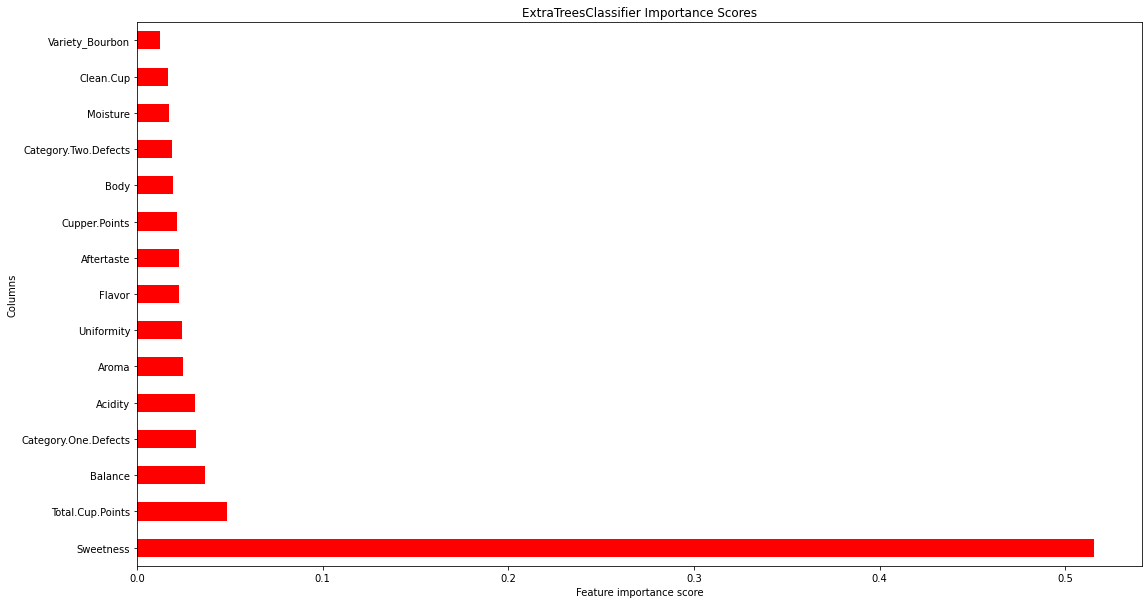

In [40]:
#plot graph of feature importances for better visualization
plt.figure(figsize=(18,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh',color='red')
plt.title('ExtraTreesClassifier Importance Scores')
plt.ylabel("Columns")
plt.xlabel("Feature importance score")
plt.show()

#### We can clearly see the features of importance from the above graph. According to my assumptions, all these features like  Sweetness, Cup points, Balance,Body ,Defects etc have high importance. The Categorical features like Country.of.Origin, Region, Variety,Producer are not having high importance. We shall not consider them in the model building phase as too many features lead to curse of dimensionality.

In [41]:
#Select the highest importance features
X=df[['Sweetness','Total.Cup.Points','Balance',
      'Category.One.Defects','Body','Acidity','Aftertaste',
      'Flavor', 'Uniformity','Cupper.Points','Aroma',        
    
      'Clean.Cup','Category.Two.Defects','Moisture',]]


<AxesSubplot:>

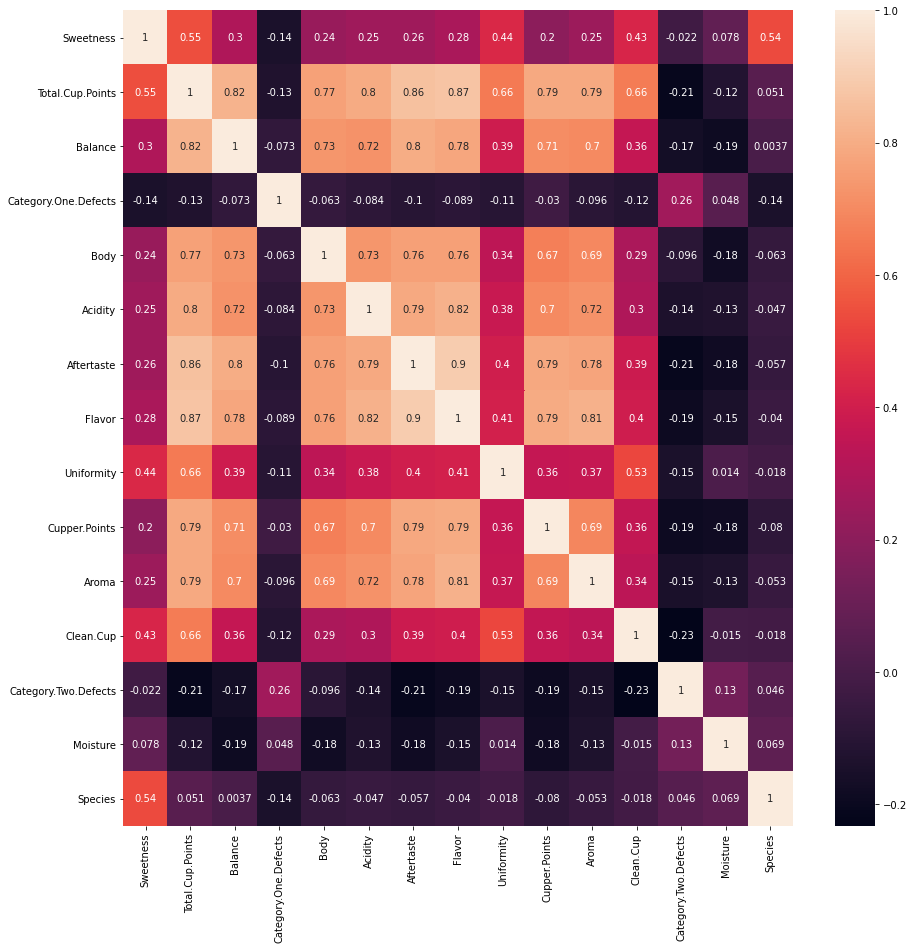

In [42]:
#plot the correlation matrix between all variables

corr_df=X.copy()               #make a copy
corr_df['Species']=y           #add column Species to corr_df
corr=corr_df.iloc[:,:].corr()  #find the correlation
top_features=corr.index
plt.figure(figsize=(15,15))     #plot the heatmap
sns.heatmap(corr_df[top_features].corr(),annot=True)

#### We can see that Sweetness is highly correlated with Species. Also, the quality measures like Aroma,Acidity,Flavor etc. are correlated with each other.

### Outlier detection and Removal

<AxesSubplot:>

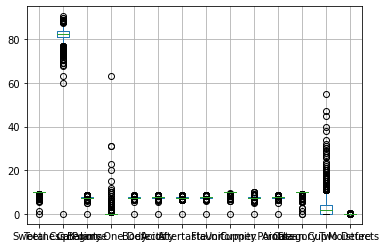

In [43]:
#plot the boxplot
X.boxplot()

#### We can observe that almost every feature has the value 0 which is clearly an outlier.Let's observe that record.

In [44]:
X[X['Sweetness']==0]

,Sweetness,Total.Cup.Points,Balance,Category.One.Defects,Body,Acidity,Aftertaste,Flavor,Uniformity,Cupper.Points,Aroma,Clean.Cup,Category.Two.Defects,Moisture
1312,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.12


#### We can see that all features for row 1312 are 0. We have to remove that row so that our model will not be effected.

In [45]:
#let's combine Species column and then remove this row which has all zeros
X=X.copy()
X['Species']=y

#drop the row
X.drop([1312], axis=0, inplace=True)

#### From the box plot above, there are no outliers present in any of the columns. We might feel that Category.Two.Defects have got outliers but it has just extreme values and we have got many values in that range. Category.One.Defects has got a value which is outside IQR. Let us see that record below

In [46]:
X[X['Category.One.Defects']>60]

,Sweetness,Total.Cup.Points,Balance,Category.One.Defects,Body,Acidity,Aftertaste,Flavor,Uniformity,Cupper.Points,Aroma,Clean.Cup,Category.Two.Defects,Moisture,Species
28,6.83,73.75,6.92,63,6.67,6.83,6.5,6.67,9.33,7.92,6.75,9.33,9,0.12,0


#### Though the value 63 is a rare value for us, considering the other important features like Sweetness, Body,Acidity,Flavor etc in that row, we cannot remove that record. Also, we can't guess what could have been the value inplace of 63. It could be anything. I will state the classifier performance if build without considering this record in the later section.Let us leave this record like this and proceed with the next part.

### Applying over sampling technique

#### As our dataset is highly imbalanced, we can't directly build the model. It can affect the performance.Machine Learning algorithms tend to produce unsatisfactory classifiers when faced with imbalanced datasets. For any imbalanced data set, if the event to be predicted belongs to the minority class and the event rate is less than 5%, it is usually referred to as a rare event.

#### Let us use SMOTETomek technique for handling the imbalanced data. imb-learn is a python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance. It is compatible with scikit-learn.

#### SMOTE is an oversampling method that synthesizes new plausible examples in the majority class.

#### Tomek Links refers to a method for identifying pairs of nearest neighbors in a dataset that have different classes. Removing one or both of the examples in these pairs (such as the examples in the majority class) has the effect of making the decision boundary in the training dataset less noisy or ambiguous.

#### Specifically, first the SMOTE method is applied to oversample the minority class to a balanced distribution, then examples in Tomek Links from the majority classes are identified and removed. [Check here](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)

### Caution

#### Before applying over-sampling technique, we have to divide the dataset into training and testing set as 
- Over-sampling will increase the data points and make the dataset balanced.In our case, we will be having equal amount of Robusta and Arabica.
- If we do over sampling and then do train-test split, there will be the problem of <b>Data Leakage</b> where information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed. This happens as we are duplicating the minority class and same points could be in both test and train sets.

#### Hence, we apply sampling technique only on training data, make the dataset balanced ,train the model and test it with original test data which we split before applying sampling.

In [47]:
#divide the dataset into train-test
y=X['Species']        #target column
X=X.iloc[:,:-1]        #independent columns


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=80)

# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
X_res,y_res=smk.fit_resample(X_train,y_train)

In [48]:
#let's check the shape of X_res and Y_res 
print(X_res.shape,y_res.shape)

#Check the Arabica and Robusta counts of sampled dataset
print(y_res.value_counts())

(2092, 14) (2092,)
1    1046
0    1046
Name: Species, dtype: int64


#### Sampling is successfully done and we have equal Robusta  and Arabica varieties now. Now ,we can build the model.

### Classfication Model Building and Evaluation

#### Let us use XGBoost and ensemble technique ,which is useful in many cases and favourite algorithm for many Kaggle winning teams.
#### In order for XGBoost to be able to use our data, we’ll need to transform it into a specific format that XGBoost can handle. That format is called DMatrix.

In [50]:
#convert the train and test datasets into DMatrix
D_train = xgb.DMatrix(X_res, label=y_res)
D_test = xgb.DMatrix(X_test, label=y_test)

#### Now that our data is all loaded up, we can define the parameters of our gradient boosting ensemble. We’ve set up some of the most important ones below. 
- max_depth (maximum depth of the decision trees being trained)
- objective (the loss function being used)
- num_class (the number of classes in the dataset)
- eta (learning rate which will prevent over-fitting of the model)

In [54]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations

In [55]:
#train the model
model = xgb.train(param, D_train, steps)

[20:14:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [65]:
#test the model
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

#Performance metrics
print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))
print("f1_score = {}".format(f1_score(y_test, best_preds)))
print("Matthews Correlation Coefficient = {}".format(matthews_corrcoef(y_test, best_preds)))

#print the classfication report
print("\n")
print("----------------Classification report---------------------------")
print(classification_report(y_test,best_preds,target_names=['Robusta','Arabica']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,best_preds))



Precision = 0.9
Recall = 0.9981060606060606
Accuracy = 0.996268656716418
f1_score = 0.9981024667931689
Matthews Correlation Coefficient = 0.892731592904439


----------------Classification report---------------------------
              precision    recall  f1-score   support

     Robusta       0.80      1.00      0.89         4
     Arabica       1.00      1.00      1.00       264

    accuracy                           1.00       268
   macro avg       0.90      1.00      0.94       268
weighted avg       1.00      1.00      1.00       268


Confusion Matrix:
[[  4   0]
 [  1 263]]


#### I have tried with various classification algorithms and selected the best one as XGBoost as it was giving best results. I have also tried building the models without sampling and with sampling. All those results are documented in the report. I tried with removing the row  where we had 'Category.One.Defects' as 63. It reduced the performance of the classifier. So, it was a good decision not removing that row. 

#### For imbalanced datasets, our evaluation metrics should not be accuracy but instead be Precision , Recall and f1_score.
- Accuracy will always be high for imbalanced datasets as it is (TP+TN)/(TP+FP+FN+TN).
- Our model should be able to do well with Precision and Recall.
- While precision refers to the percentage of our results which are relevant, recall refers to the percentage of total relevant results correctly classified by our algorithm.
- f1 score is a harmonic mean of precision and recall. For problems where both precision and recall are important like this one, we should select a model with high f1 score.
- The higher the correlation between true and predicted values, the better the prediction. This is the phi-coefficient (φ), rechristened Matthews Correlation Coefficient (MCC).
- MCC takes into account all four values in the confusion matrix, and a high value (close to 1) means that both classes are predicted well, even if one class is disproportionately under- (or over-) represented.
- By observing the confusion matrix, we have one false negative where a 0(Robusta) was predicted as 1(Arabica).

# Clustering 

In [150]:
#import the necessary libraries
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [151]:
#Create a copy of our dataset
cdf=X.copy()

#append the Species column to the copied dataframe
cdf['Species']=y

In [152]:
# standardizing the data

scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03
mean,7.434677e-16,1.784323e-15,-2.718968e-15,5.310484e-18,6.797419e-16,-2.336613e-15,-2.081710e-15,-1.486935e-15,-2.825177e-15,-9.346452e-16,1.699355e-15,1.869290e-15,4.248387e-17,-8.496774e-17
std,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00
min,-1.500861e+01,-8.310641e+00,-6.775764e+00,-1.881908e-01,-7.737914e+00,-7.181678e+00,-3.531435e+00,-4.237439e+00,-7.922099e+00,-5.481777e+00,-7.892278e+00,-1.376513e+01,-6.696726e-01,-1.830081e+00
25%,2.440861e-01,-3.904537e-01,-5.350378e-01,-1.881908e-01,-6.683824e-01,-6.623904e-01,-4.472481e-01,-5.744867e-01,3.253040e-01,-6.069689e-01,-4.824666e-01,2.203285e-01,-6.696726e-01,3.405666e-02
50%,2.440861e-01,1.298642e-01,-6.351631e-02,-1.881908e-01,-9.058421e-02,1.211778e-01,3.822579e-02,1.581037e-01,3.253040e-01,-2.105439e-02,2.418723e-02,2.203285e-01,-2.931928e-01,4.483095e-01
75%,2.440861e-01,5.654791e-01,6.298977e-01,-1.881908e-01,4.872140e-01,6.540042e-01,4.951424e-01,6.562652e-01,3.253040e-01,5.648601e-01,5.625069e-01,2.203285e-01,8.328701e-02,6.554359e-01
max,2.440861e-01,3.138214e+00,3.403554e+00,2.452109e+01,3.580134e+00,3.788277e+00,3.607887e+00,3.821056e+00,3.253040e-01,5.838090e+00,3.729093e+00,2.203285e-01,9.683522e+00,3.969459e+00


#### Our dataset has 15 features which are quite more for distance based algorithms like kmeans. Let us reduce the dimensions by applying Principal Component Analysis

In [153]:
#initialise the PCA with 2 components
pca=PCA(n_components=2)

#apply PCA to our scaled dataset
pca.fit(data_scaled)
x_pca=pca.transform(data_scaled)

Text(0, 0.5, 'Second principle component')

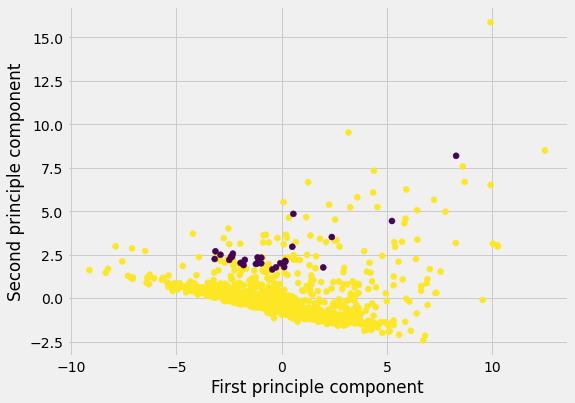

In [154]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=y)
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

Text(0, 0.5, 'Inertia')

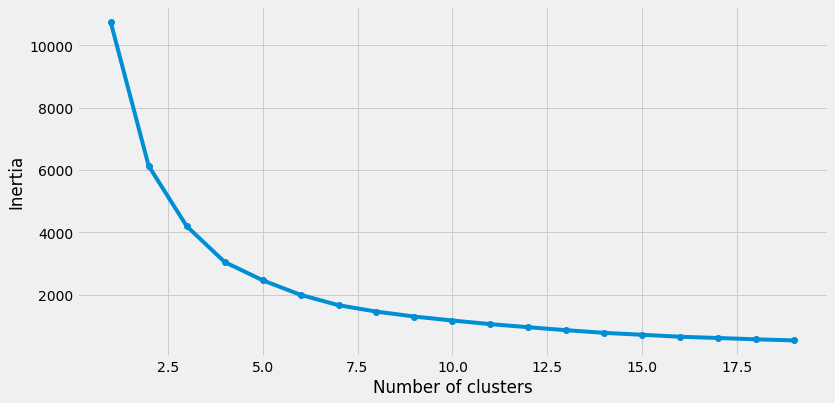

In [155]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(x_pca)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [156]:
kl = KneeLocator(range(1, 20),SSE, curve="convex", direction="decreasing")
kl.elbow

5

In [157]:
kmeans = KMeans( n_clusters = 5, init='k-means++')
kmeans.fit(x_pca)
y_kmeans = kmeans.predict(x_pca)

In [158]:
kmeans.inertia_

2457.451923345097

In [159]:
frame = pd.DataFrame(x_pca)
frame['cluster'] = pred
frame['cluster'].value_counts()

4    649
1    302
0    295
3     52
2     40
Name: cluster, dtype: int64

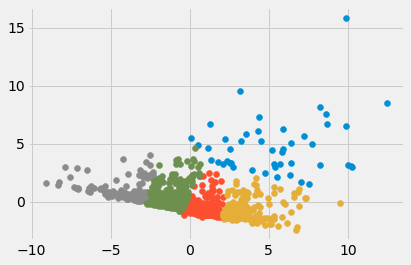

In [160]:
# retrieve unique clusters
clusters = np.unique(y_kmeans)

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(y_kmeans == cluster)
    # create scatter of these samples
    plt.scatter(x_pca[row_ix, 0], x_pca[row_ix, 1])
    
# show the plot
plt.show()

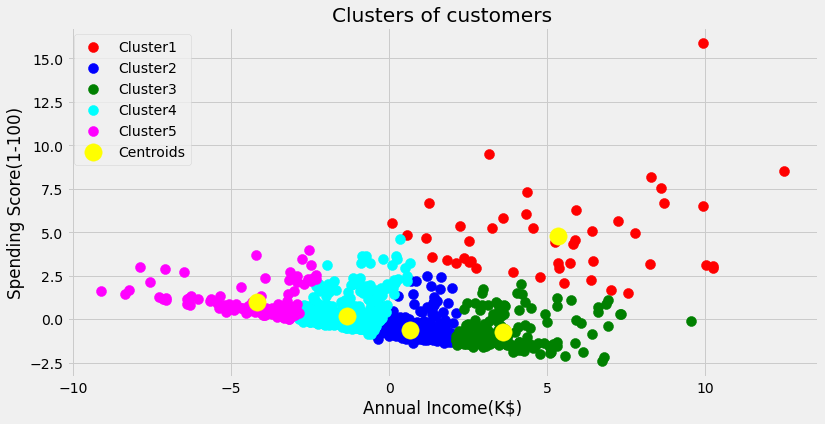

In [161]:
plt.figure(figsize=(12,6))
plt.scatter(x_pca[y_kmeans==0,0],x_pca[y_kmeans==0,1],s=100,c='red',label='Cluster1')
plt.scatter(x_pca[y_kmeans==1,0],x_pca[y_kmeans==1,1],s=100,c='blue',label='Cluster2')
plt.scatter(x_pca[y_kmeans==2,0],x_pca[y_kmeans==2,1],s=100,c='green',label='Cluster3')
plt.scatter(x_pca[y_kmeans==3,0],x_pca[y_kmeans==3,1],s=100,c='cyan',label='Cluster4')
plt.scatter(x_pca[y_kmeans==4,0],x_pca[y_kmeans==4,1],s=100,c='magenta',label='Cluster5')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=300,c='yellow',label='Centroids')

plt.title('Clusters of customers')
plt.xlabel('Annual Income(K$)')
plt.ylabel('Spending Score(1-100)')
plt.legend()

plt.show()

In [162]:
#silhoutte
from sklearn.metrics import silhouette_score
silhouette_coefficients = []

In [163]:
for k in range(2, 20):
        
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x_pca)
        score = silhouette_score(x_pca, kmeans.labels_)
        silhouette_coefficients.append(score)

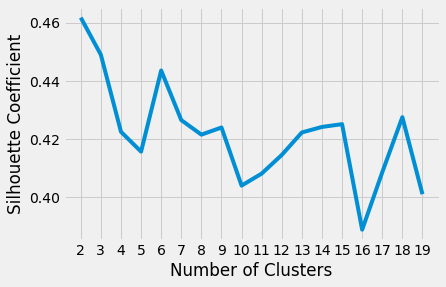

In [164]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [98]:
from sklearn.cluster import DBSCAN

In [109]:
dbscan = DBSCAN(eps=0.3,min_samples=9)
kmeans = KMeans(n_clusters=5)

# Fit the algorithms to the features
kmeans.fit(x_pca)
dbscan.fit(x_pca)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(x_pca, kmeans.labels_).round(2)
dbscan_silhouette = silhouette_score(x_pca, dbscan.labels_).round(2)

In [168]:
print(kmeans_silhouette)

0.45


In [169]:
print(dbscan_silhouette)

0.46


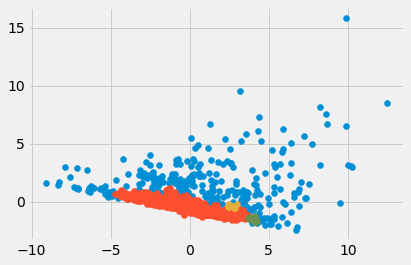

In [167]:
y_kmeans = dbscan.fit_predict(x_pca)
# retrieve unique clusters
clusters = np.unique(y_kmeans)

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(y_kmeans == cluster)
    # create scatter of these samples
    plt.scatter(x_pca[row_ix, 0], x_pca[row_ix, 1])
    
# show the plot
plt.show()

In [170]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

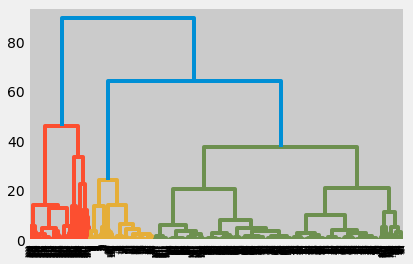

In [171]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(x_pca, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(x_pca)

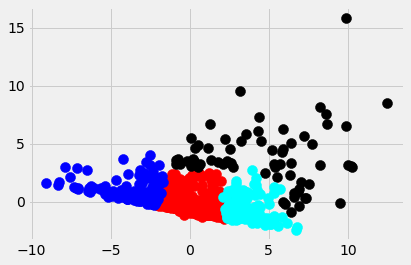

In [173]:
plt.scatter(x_pca[y_hc ==0,0], x_pca[y_hc == 0,1], s=100, c='red')
plt.scatter(x_pca[y_hc==1,0], x_pca[y_hc == 1,1], s=100, c='black')
plt.scatter(x_pca[y_hc ==2,0], x_pca[y_hc == 2,1], s=100, c='blue')
plt.scatter(x_pca[y_hc ==3,0], x_pca[y_hc == 3,1], s=100, c='cyan')

In [174]:
from sklearn.mixture import GaussianMixture

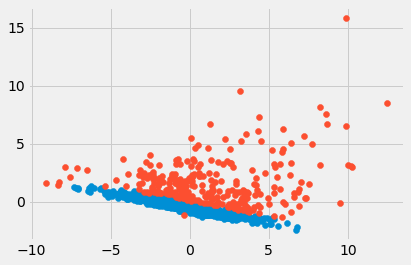

In [179]:
model = GaussianMixture(n_components=2)
# fit the model
model.fit(x_pca)
# assign a cluster to each example
yhat = model.predict(x_pca)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(x_pca[row_ix, 0], x_pca[row_ix, 1])
# show the plot
plt.show()